# <center> Heart Failure Prediction - Classification

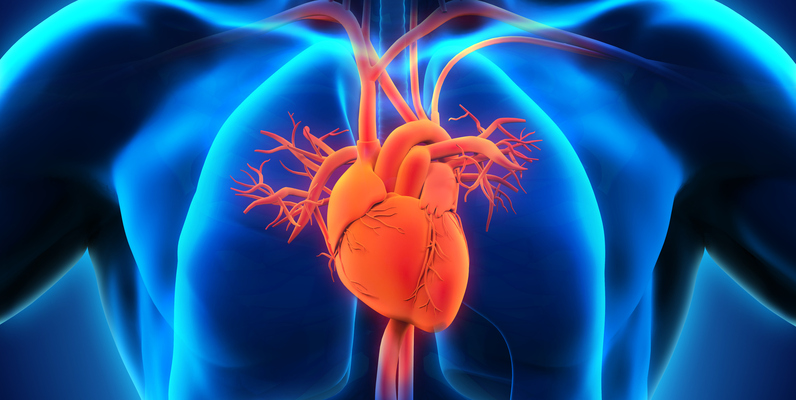

## Introduction

In this notebook, I'll be focusing on performing machine learning (ML) models for a binary classification to predict heart failure ([Data Source](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)). Also, I'll go in every step needed taken to correctly do so. Firstly, I'll do some basic exploration in the data to underestend it and then prepare it for fit in the model. To make a inicial seach to see which models better fit the data (preset more accurate) will be used `RandomizedSearchCV` which is much faster than GridSearchCV, but not necessarily presents the best result (because it's random 😁). To evaluate these models the metrics that will be used are:

* Accuracy
* ROC, AUC
* Confusion Matrix
* Classification Report

**Data content:**

* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='viridis',
#              font='Lucida Calligraphy',
              font_scale=1.3,
              color_codes=True,
              rc=None)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE # to balance the dataset

from IPython.display import display, Markdown

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Dataset

In [3]:
df = pd.read_csv('heart_binary.csv')

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='viridis')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000
HeartDisease,918.000000,0.553377,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000


* The dataset contains 12 columns with 918 observations, and there are no missing values.
* There are some categorical features in our data - features in Dtype: object. So we will need to encode them into numeric later.
* However, the data types for some columns are not matched. Below will fixed the data types for those column before analysis performed.

## Basic Exploratory Data Analysis (EDA)

In this section will focused on initial data exploration before applying ML models.

In [7]:
df1 = df.copy()
#Sex
le = LabelEncoder()
le.fit(df1.Sex.drop_duplicates()) 
df1.Sex = le.transform(df1.Sex)
#ChestPainType
le.fit(df1.ChestPainType.drop_duplicates()) 
df1.ChestPainType = le.transform(df1.ChestPainType)
#RestingECG
le.fit(df1.RestingECG.drop_duplicates()) 
df1.RestingECG = le.transform(df1.RestingECG)
#ExerciseAngina
le.fit(df1.ExerciseAngina.drop_duplicates()) 
df1.ExerciseAngina = le.transform(df1.ExerciseAngina)
#ST_Slope
le.fit(df1.ST_Slope.drop_duplicates()) 
df1.ST_Slope = le.transform(df1.ST_Slope)

<AxesSubplot:>

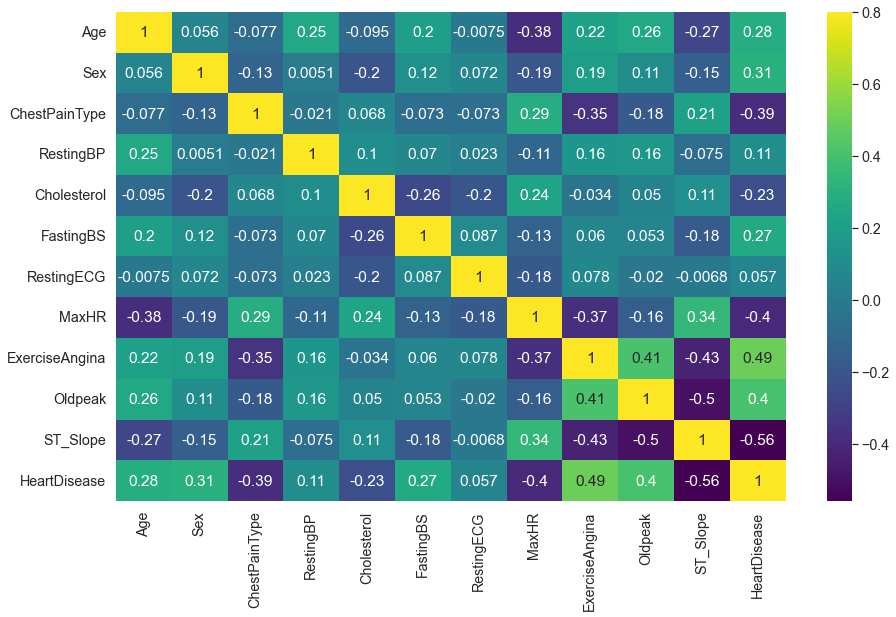

In [8]:
corrmat = df1.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.8, annot=True, cmap='viridis')

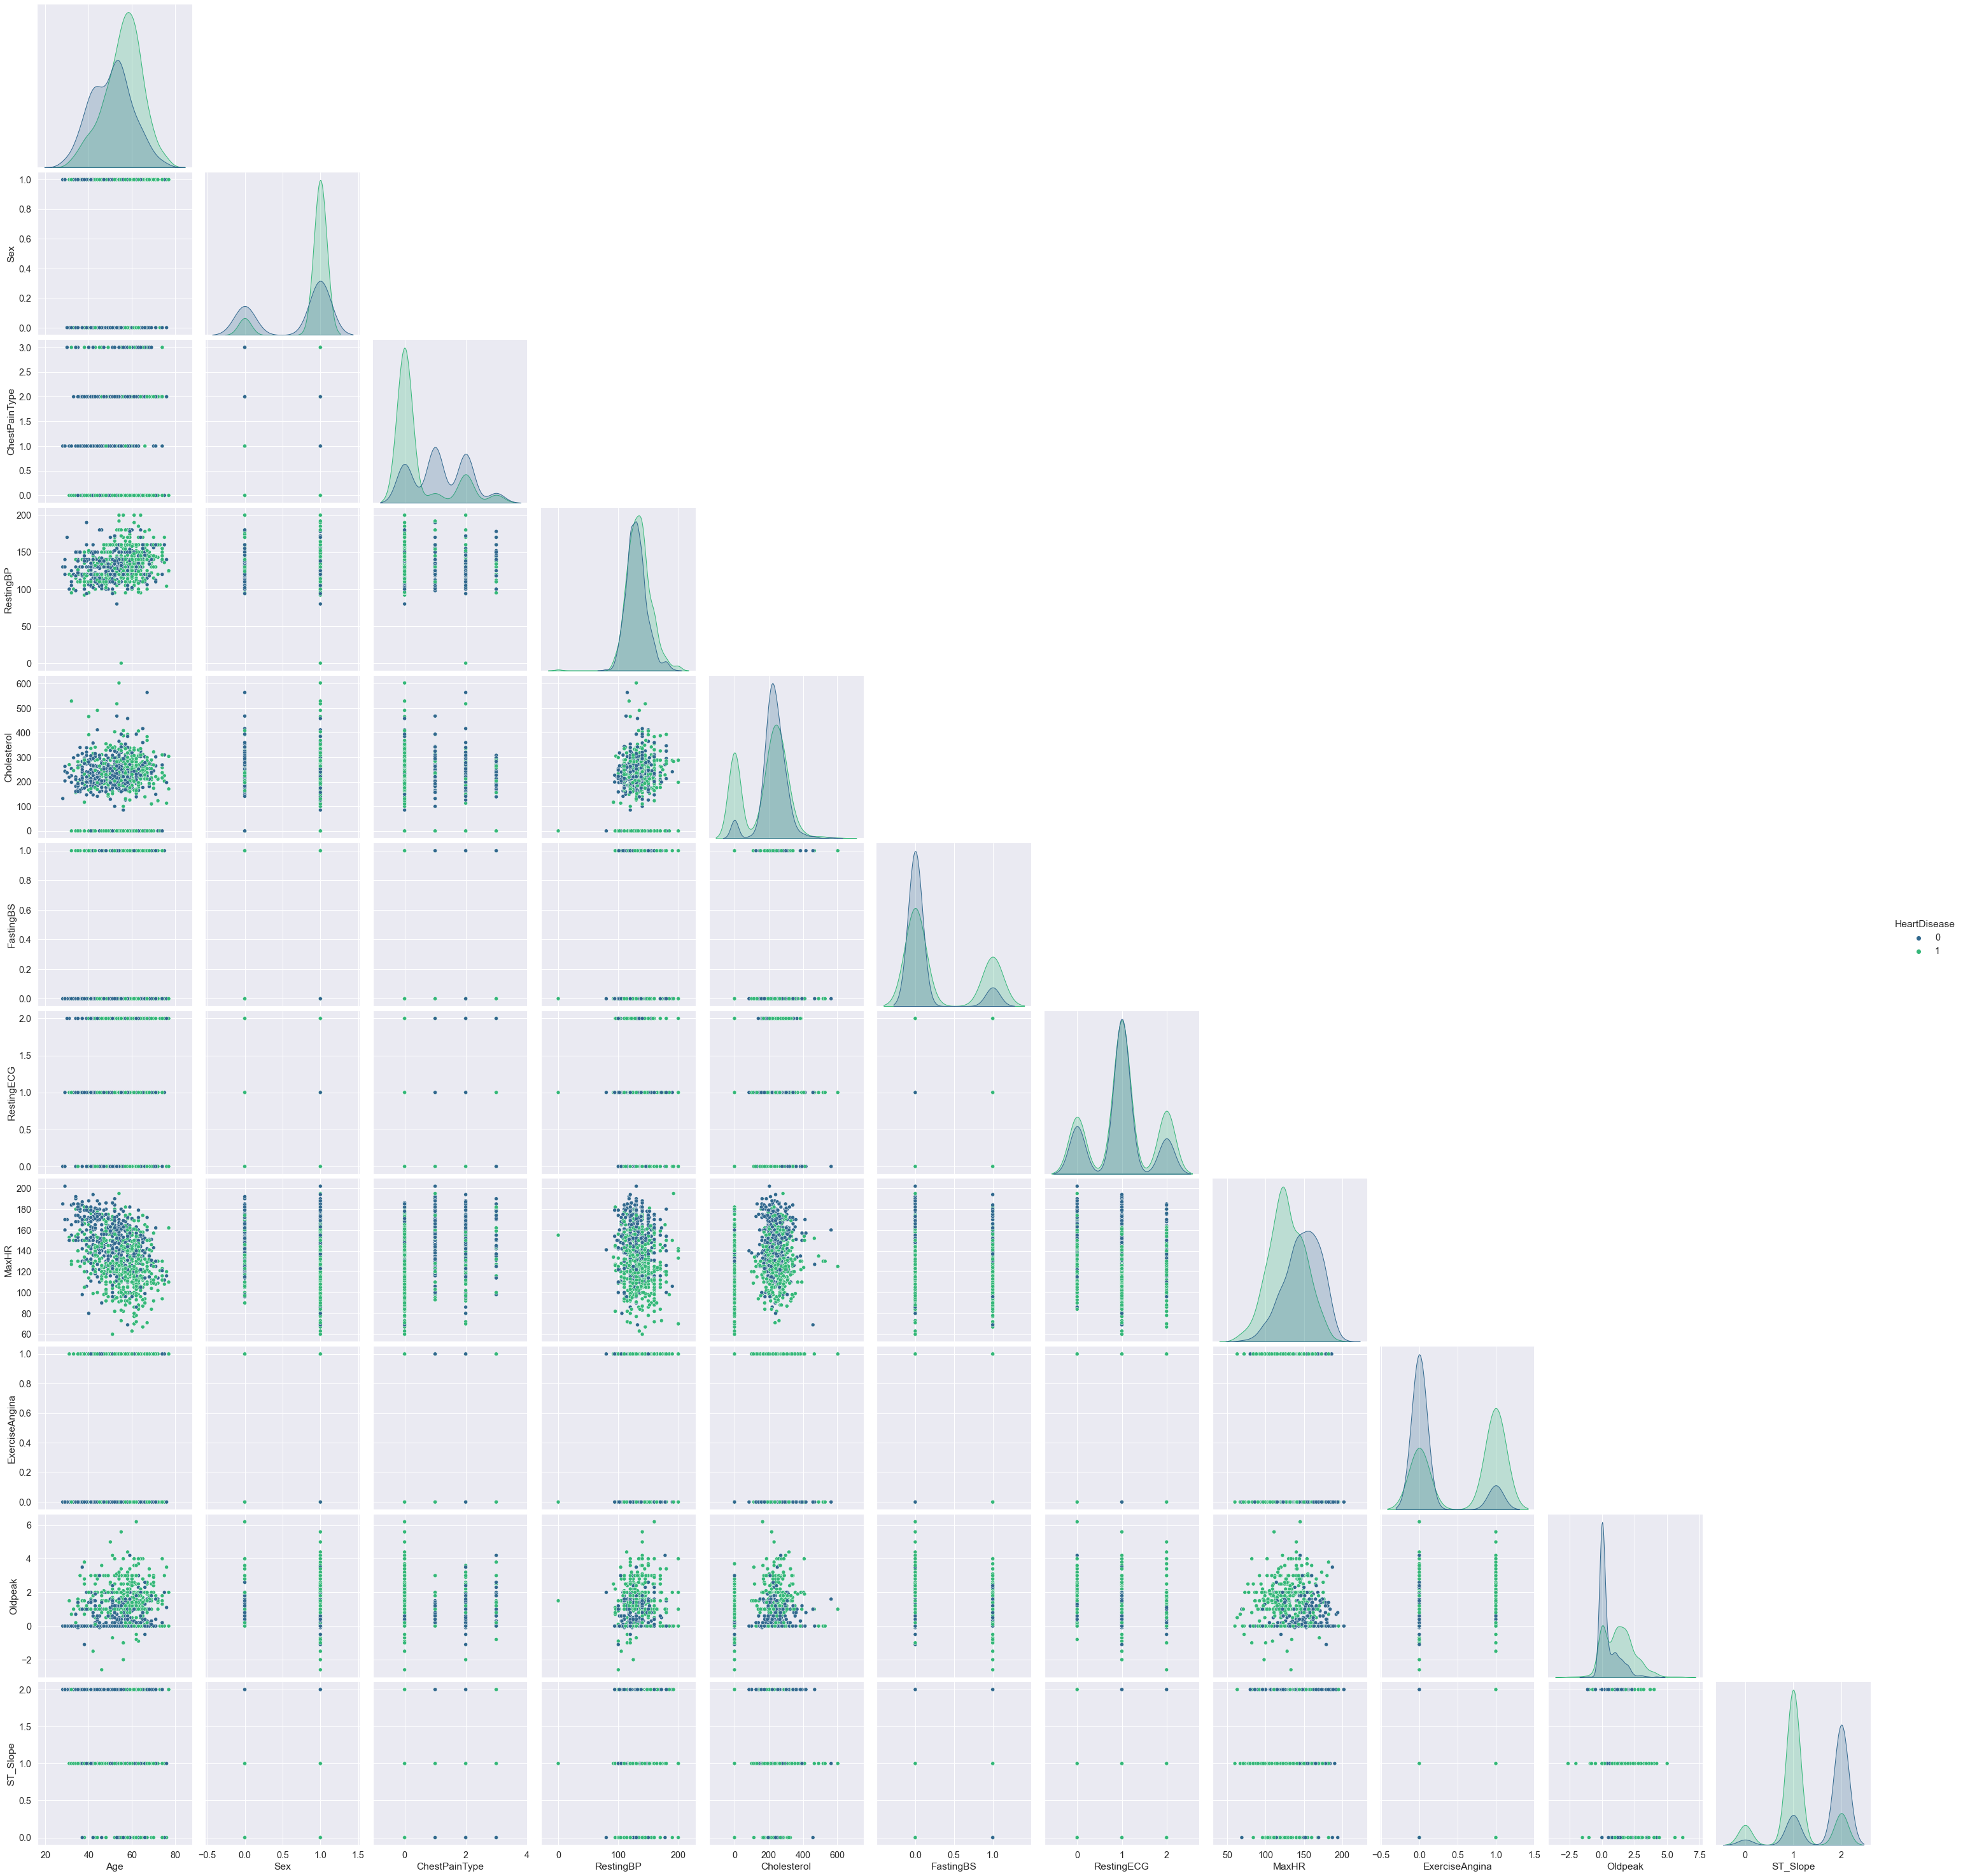

In [9]:
sns.pairplot(data=df1, hue='HeartDisease', corner=True, palette='viridis', height=3.8, aspect=1)

In [10]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Text(0.5, 1.0, 'Age Distributions')

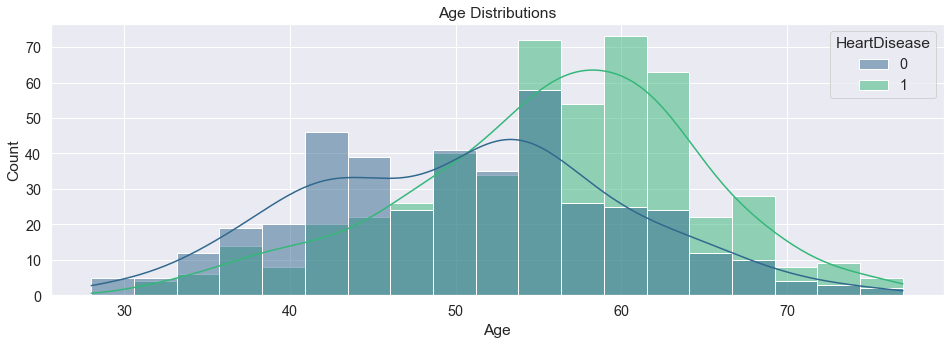

In [11]:
plt.figure(figsize=(16,5)) 
fig = sns.histplot(x=df['Age'], hue=df['HeartDisease'], kde=True, palette='viridis')
fig.set_title("Age Distributions")

Text(0.5, 1.0, 'Gender Distribution')

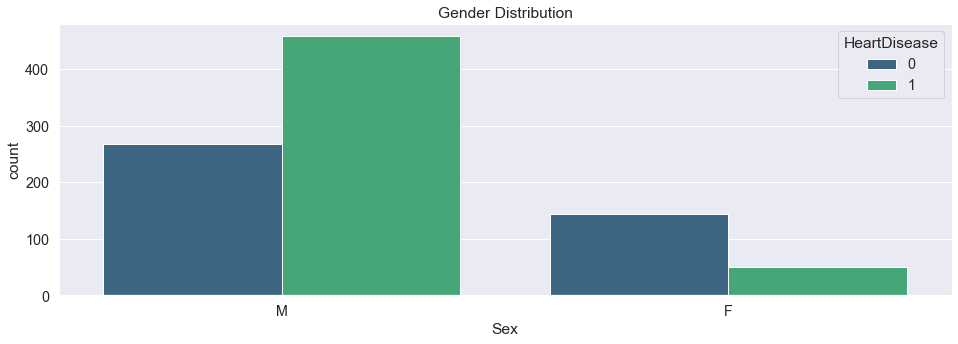

In [12]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["Sex"], hue=df['HeartDisease'], palette='viridis')
fig.set_title("Gender Distribution")

Text(0.5, 1.0, 'Prevalence of Chest Pain in Heart Disease')

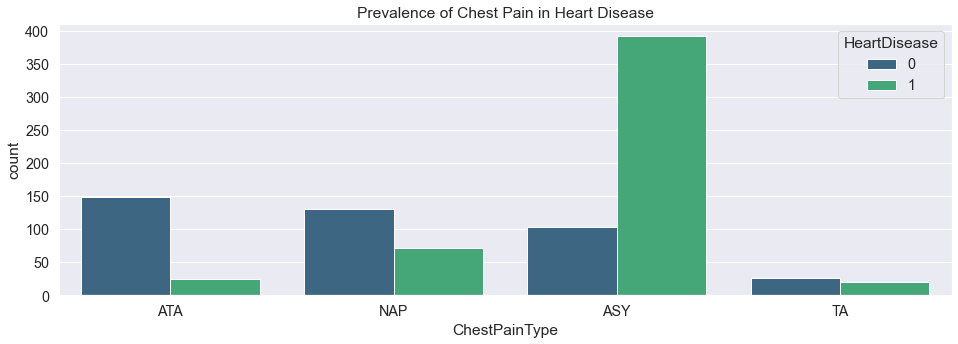

In [13]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["ChestPainType"], hue=df['HeartDisease'], palette='viridis')
fig.set_title("Prevalence of Chest Pain in Heart Disease")

Text(0.5, 1.0, 'Prevalence of Chest Pain in Heart Disease')

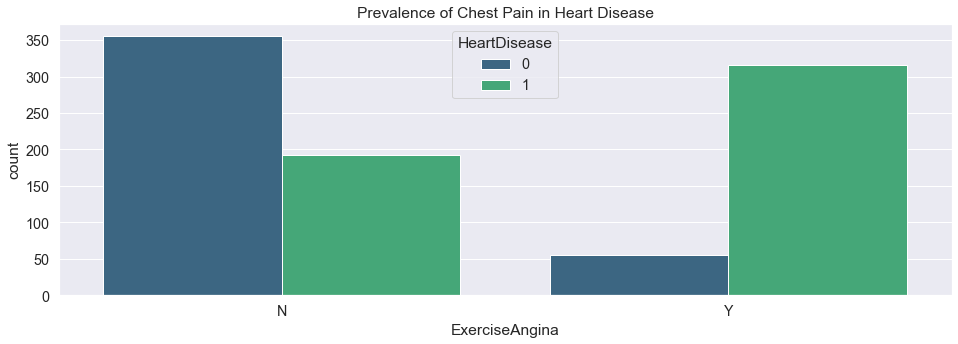

In [14]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["ExerciseAngina"], hue=df['HeartDisease'], palette='viridis')
fig.set_title("Prevalence of Chest Pain in Heart Disease")

Text(0.5, 1.0, 'Prevalence of Chest Pain in Heart Disease')

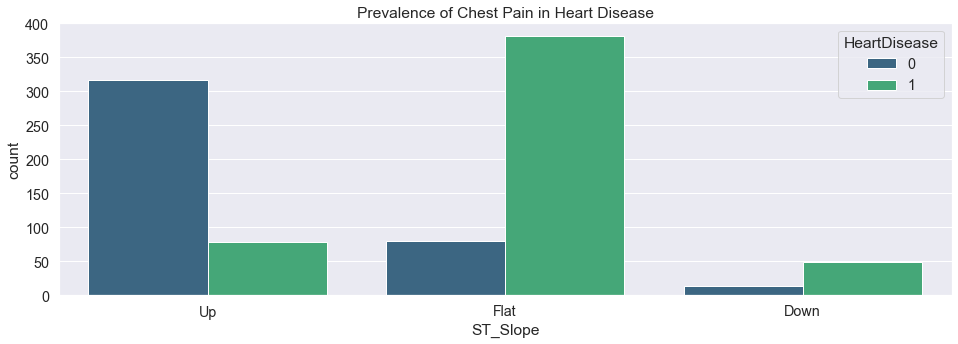

In [15]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["ST_Slope"], hue=df['HeartDisease'], palette='viridis')
fig.set_title("Prevalence of Chest Pain in Heart Disease")

Before entering in the next section it's worth to mention that a deeper analysis could be done, but the main point is to model and evaluate the algorithms.

## Data Preprocessing

In this section, I will be preprocessing the data to fit it in the model.

**The following steps are applied to preprocess the data:**

* One hot encoding the categorical features - transform categorical features into numerical feature, since it's necessary to into into the model
* Scaling the features using the standard scaler - normalizes the data into a same scale

In [16]:
X = df.copy()
y = X.pop('HeartDisease')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
#y = np.log(y) # log transform target instead of standardizing

## Modelling

Now that the data is ready, I will be fitting it into some classification models such as `Logistic Regression`, `K-Nearest Neighbor`, `Support Vector Machine (SVM)`, `Decision Tree and Random Forest`.

**Steps involved in this section:**

* Brief description of the models to be used
* RandomizedSearchCV to determine the models that best fit the data
* Creating train and test dataset
* Use metrics and hyperparameters to improve models

**Logistic Regression**

<img src='https://pimages.toolbox.com/wp-content/uploads/2022/04/11040522/46-4.png'>

Source: [What Is Logistic Regression? Equation, Assumptions, Types, and Best Practices](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/)

Despite the name, Logistic Regression is used for classification tasks, more specifically binary classification, that is, values like 0 or 1, yes or no, true or false based on a set of independent variables. This algorithm calculates the probability of occurrence of an event and as a function of this the values of are between 0 and 1. Generally 0.5 is the threshold, where if the output is 0.51, for example the model will predict it as 1 or yes; for values less than 0.5 the output is 0 or false, eg.

**Decision Tree**

<img src='https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/df/de/Decision-Tree.component.xl.ts=1640802170790.png/content/adobe-cms/us/en/topics/decision-trees/jcr:content/root/table_of_contents/intro/complex_narrative/items/content_group_1423241468/image'>

Source: [What is a Decision Tree | IBM](https://www.ibm.com/topics/decision-trees)
Decision Tree is one of the most popular machine learning algorithms because it is very versatile - it can be used for both regression and classification. This, as its name implies, works in the form of decision-making. The algorithm uses the sampling of data by splitting the it into parts. The tree structure consists of a root node, branches, internal nodes and leaf nodes. The root node represents the most important variable of the database, branches are pretty explanatory, internal nodes are the other variables - which are ordered from most to least important in the tree structure, and the leaf nodes is the end point where a decision is made.

**Random Forest**

<img src='https://1.cms.s81c.com/sites/default/files/2020-12-07/Random%20Forest%20Diagram.jpg'>

Source: [What is Random Forest?](https://www.ibm.com/topics/decision-trees)

Random forests are a ensemble learning technique that is based on decision trees. While an individual decision tree has one result and a narrow range of groups, the forest guarantees a more accurate result, with a greater number of groups and decisions. It has the added benefit of bringing randomness to the model, as each tree selects random variables from the main database.

**k-Nearest Neighbours (kNN)**

<img src='https://miro.medium.com/max/1200/0*OltO4Txr-D0lPWNL.png'>

Source: [K-Nearest Neighbor. A complete explanation of K-NN | by Antony Christopher | The Startup | Medium](https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4)

kNN is a very simple algorithm, which can also be used for both regression and classification. Basically, the algorithm considers that neighboring data points are not similar. This similarity is measured through the distance between the data points, which can be Euclidean distance, Hamming distance, Manhattan distance, and Minkowski distance. The k refers to the number of neighbors - in the case of regression, the mean can be taken from these k neighbors for the prediction and in the case of classification the frequency.

**Support Vector Machine (SVM)**

<img src='https://miro.medium.com/max/1400/1*ZpkLQf2FNfzfH4HXeMw4MQ.png'>

Source: [Support Vector Machine — Introduction to Machine Learning Algorithms | by Rohith Gandhi | Towards Data Science](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

Support Vector Machine (SVM) is a popular machine learning method that can be used both for solving classification and regression problems. Support Vector Machine achieves classification by spliting the data points with a hyperplane (also called a decision boundary). For example, in cases where there are only 2 input variables (2-dimensional), the decision boundary is simply a straight line. In 3-dimensional cases, the decision boundary becomes a plane as shwon in the image above.

**Gradient Boosting**

<img src='https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-Lw6zezdliKWkGknCJ6R%2F-Lw70ZzNl5AgerhBsp-v%2Fimage.png?alt=media&token=5df440f0-a102-454e-9d43-e07549dd5334'>

Source: [Gradient Boosting - AI Wiki](https://machine-learning.paperspace.com/wiki/gradient-boosting) 

XGBoost is an algorithms that can be applyed to both regression and classification.
"Gradient boosting (derived from the term gradient boosting machines) is a popular supervised machine learning technique for regression and classification problems that aggregates an ensemble of weak individual models to obtain a more accurate final model ... XGBoost is a very popular gradient boosting framework that is fast, uses some clever tricks to obtain more accurate results, and is easy to parallelize.  " - [Gradient Boosting - AI Wiki](https://machine-learning.paperspace.com/wiki/gradient-boosting)  

### Best Models to fit the data

In [17]:
model_params = {
    'logistic_regression' : {
        'model' : LogisticRegression(),
        'params' : {
            'penalty' : np.array(['l1', 'l2', 'elasticnet', 'none']),
            'max_iter' : np.arange(25, 250, 25),
            'C' : np.arange(0.01, 1, 0.01),
            'solver' : np.array(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
        }
    },
    'decision_tree' : {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': np.array(["gini", "entropy"]),
            'max_depth': np.array([None, 1, 3, 5, 7, 8, 9]),
            'min_samples_split' : np.arange(1, 4, 1),
            'min_samples_leaf' : np.arange(1, 4, 1),
            'max_features' : np.array([None, "auto", "sqrt", "log2"])
        }

    },
    'random_forest' : {        
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': np.arange(50, 650, 50),
            'max_features' : np.array([None, "auto", "sqrt", "log2"]),
            'max_depth' : np.array([None, 1, 3, 5, 7, 8, 9]),
            'min_samples_split' : np.arange(1, 4, 1),
            'min_samples_leaf' : np.arange(1, 4, 1),
            'bootstrap': np.array([False, True])
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : [2, 3, 4, 5, 7],
            'weights' : np.array(['uniform', 'distance']),
            'leaf_size' : np.arange(2, 60, 2),
            'p' : np.arange(1, 6, 1)
        }
        
    },
    'svm' : {
        'model': SVC(),
        'params': {
            'gamma': ['auto', 'scale'],
            'C': [1, 3, 5, 7, 10],
            'kernel': np.array(['linear', 'poly', 'rbf', 'sigmoid'])
        }
    },
    'xgb' : {
        'model': XGBClassifier(),
        'params': {
            'n_estimators' : np.arange(50, 650, 50),
#            'max_features' : np.array([2, 3, 4, 5, 6]),
            'learning_rate' : np.arange(1, 0.01, -0.1),
#            'eta': np.array([.03, .07, 0.1]), #(eta or shrinkage)
#            'min_child_weight' : np.array([.5, 1]),
#            'max_depth' : np.array([4, 5, 6, 7, 9, 8]),
            'subsample' : np.arange(2, 0.5, -0.5)
        }
    }
}

In [18]:
scores = []

for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [19]:
scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
scores.sort_values(by='best_score', ascending=False)

,model,best_score,best_params
4,svm,0.835489,"{'kernel': 'poly', 'gamma': 'auto', 'C': 1}"
2,random_forest,0.834331,"{'n_estimators': 450, 'min_samples_split': 2, ..."
0,logistic_regression,0.833292,"{'solver': 'saga', 'penalty': 'l1', 'max_iter'..."
3,knn,0.832163,"{'weights': 'distance', 'p': 2, 'n_neighbors':..."
1,decision_tree,0.815764,"{'min_samples_split': 2, 'min_samples_leaf': 2..."
5,xgb,0.811446,"{'subsample': 1.0, 'n_estimators': 200, 'learn..."


It seems that all models presented very similar results, as a result of which they will all be used for further evaluation.

### Split train and test data

Train/Test Split involves splitting the dataset into training and testing sets respectively. After which, you train with the training set and test with the testing set. This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
for i in range(len(scores)):
    print(scores['model'][i])
    print(scores['best_params'][i])
    print('\n'+'---'*5)

logistic_regression
{'solver': 'saga', 'penalty': 'l1', 'max_iter': 200, 'C': 0.29000000000000004}

---------------
decision_tree
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}

---------------
random_forest
{'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}

---------------
knn
{'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'leaf_size': 10}

---------------
svm
{'kernel': 'poly', 'gamma': 'auto', 'C': 1}

---------------
xgb
{'subsample': 1.0, 'n_estimators': 200, 'learning_rate': 0.5000000000000001}

---------------


In [22]:
#LogisticRegression
lr_model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=150, C=0.86)
lr_model.fit(X_train, y_train)
#Predicting vector for LogisticRegression
y_pred_lr = lr_model.predict(X_test)

In [23]:
#DecisionTree
dt_model = DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto', max_depth= 7, criterion= 'entropy')
dt_model.fit(X_train, y_train)
#Predicting vector for RandomForest
y_pred_dt = dt_model.predict(X_test)

In [24]:
#RandomForest
rf_model = RandomForestClassifier(n_estimators=150, min_samples_leaf=2, min_samples_split=3, max_features='sqrt', max_depth=1, bootstrap=True)
rf_model.fit(X_train, y_train)
#Predicting vector for DecisionTree
y_pred_rf = rf_model.predict(X_test)

In [25]:
#KNN
knn_model = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=5, leaf_size=20)
knn_model.fit(X_train, y_train)
#Predicting vector for KNN
y_pred_knn = knn_model.predict(X_test)

In [26]:
#SVC
svc_model = SVC(kernel='poly', gamma='auto', C=3, probability=True)
svc_model.fit(X_train, y_train)
#Predicting vector for SVC
y_pred_svc = svc_model.predict(X_test)

In [27]:
#XGBoost
xgb_model = XGBClassifier(n_estimators=50, subsample=1, learning_rate=0.2)
xgb_model.fit(X_train, y_train)
#Predicting vector for XGBoost
y_pred_xgb = xgb_model.predict(X_test)

### Model Evaluation

### <center> KNN

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




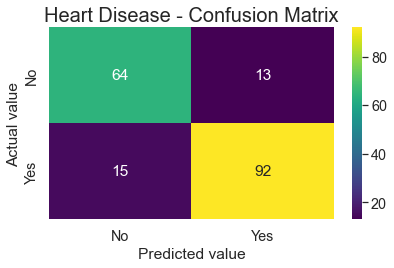

### <center> Decision Tree

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




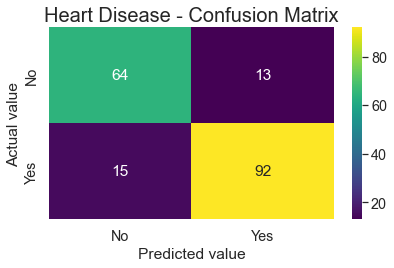

### <center> Random Forest

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




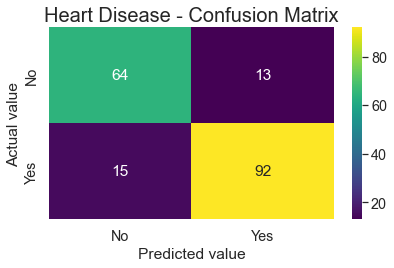

### <center> SVC

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




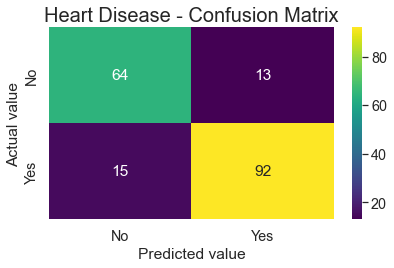

### <center> Logistic Regression

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




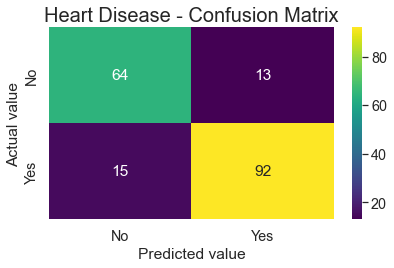

### <center> XGBoost

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.85      0.85       184




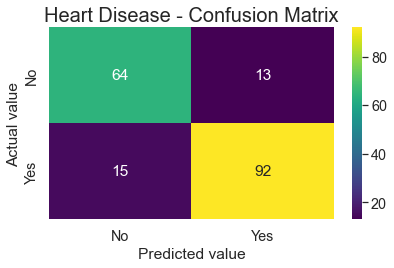

In [28]:
def metrics (model, y_test, y_pred):
    display(Markdown('### <center> {}'.format(model)))
    print('Classification Report: \n\n', classification_report(y_test, y_pred))
    print()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.4g')
    plt.title('Heart Disease - Confusion Matrix', fontdict={'size':20})
    plt.xticks([0.5, 1.5], ['No', 'Yes'])
    plt.yticks([0.5, 1.5], ['No', 'Yes'])
    plt.ylabel('Actual value')
    plt.xlabel('Predicted value')
    plt.tight_layout()
    plt.show()
    
metrics('KNN', y_test, y_pred_knn)
metrics('Decision Tree', y_test, y_pred_knn)
metrics('Random Forest', y_test, y_pred_knn)
metrics('SVC', y_test, y_pred_knn)
metrics('Logistic Regression', y_test, y_pred_knn)
metrics('XGBoost', y_test, y_pred_knn)

In [29]:
def roc (model, X_test, y_test):
    for i in model:
        y_prob = i.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        #roc curve
        plt.figure(figsize = (10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
        plt.plot([0, 1], [0, 1], linestyle = '--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC curves from the investigated models')
        plt.legend(loc='best')
    plt.show()

In [30]:
# Instantiate the classfiers and make a list
classifiers = [knn_model, dt_model, rf_model, svc_model, lr_model, xgb_model]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

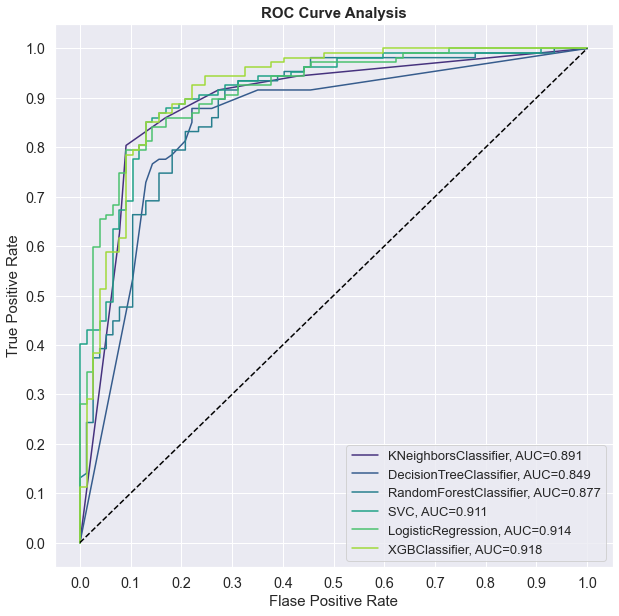

In [31]:
fig = plt.figure(figsize=(10,10))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

It seems that there was not a big difference between the performance of these algorithms, especially when comparing accuracy and hit rate in the confusion matrices. However, with the ROC curve and AUC, it can be observed that XGBoost, SVC and Logistic Regression did a little better.

# <center> References

* [Machine Learning with Python - Introduction to Machine Learning | Coursera](https://www.coursera.org/learn/machine-learning-with-python)
* [Top 6 Machine Learning Algorithms for Classification | by Destin Gong | Towards Data Science](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)
* [How to Choose Right Metric for Evaluating ML Model | Kaggle](https://www.kaggle.com/code/vipulgandhi/how-to-choose-right-metric-for-evaluating-ml-model/notebook)
* [Drawing multiple ROC-Curves in a single plot](https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot)